In [798]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

### Task 1: we will modify the given image below (remove the unecessary borders)

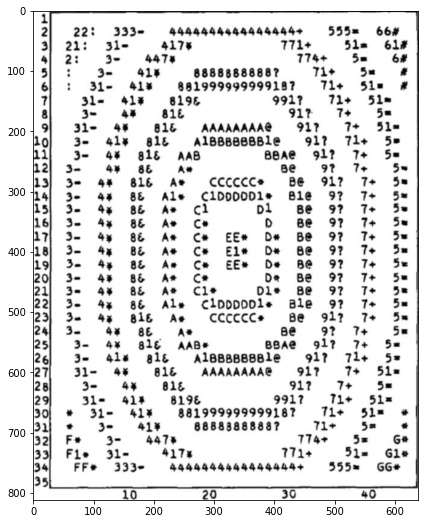

In [799]:
# Modify directory path string to accommodate "your" relative path.
img = cv2.imread('/Users/johnsonFreemanClarke/Desktop/5190/images/fig1.jpg', 0)

# Using the given pic from assignment #3 
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.rcParams["figure.figsize"] = [15, 9]
plt.show()

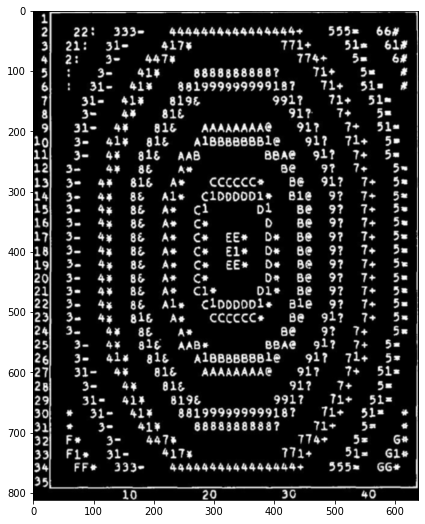

In [800]:
# Convert pic from white to black background
inverted_img = img.copy()
inverted_img = cv2.bitwise_not(inverted_img)
plt.imshow(inverted_img, cmap = 'gray', interpolation = 'bicubic')
# plt.rcParams["figure.figsize"] = [15, 9]
plt.show()

In [801]:
# Save a copy of inverted_img to respective directory path
status = cv2.imwrite('/Users/johnsonFreemanClarke/Desktop/5190/images/invertedFig1.jpg', inverted_img)
if status != True:
    print('Please check your directory file path name and try again')

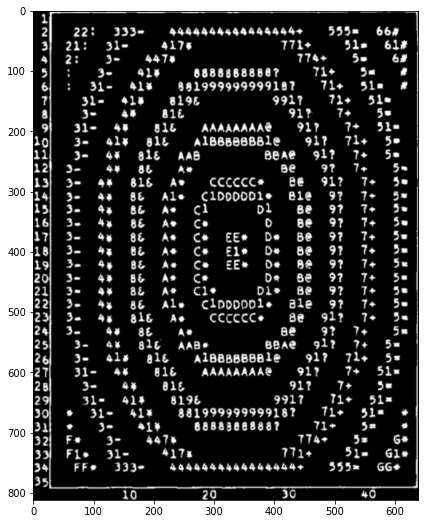

In [802]:
# Before using the findContours function we want to remove noise via smoothing 
# and also to preserve edges.
inverted_img = cv2.bilateralFilter(inverted_img, 9, 75, 75)

# Applying threshold to get true binary image
# ret is the optimal threshold value for using Otsu's thresholding
ret, inverted_img = cv2.threshold(inverted_img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# ret, inverted_img = cv2.threshold(inverted_img, 0, 255, cv2.THRESH_BINARY)

plt.imshow(inverted_img, cmap = 'gray', interpolation = 'bicubic')
# plt.rcParams["figure.figsize"] = [15, 9]
plt.show()

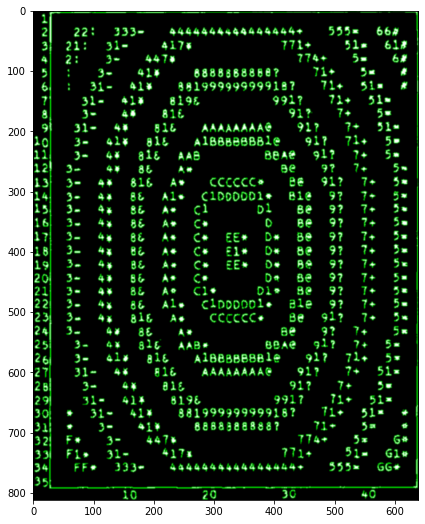

In [803]:
# image_space is the modified images
# contours is a list of contours found; each individual contour is a numpy array of coords of boundary 
# points of the object. Format is as follows: number of points 
# hierarchy describes the structure of the contours returned, each entry contains an array of 4 elements
contour_img = inverted_img.copy() 
image_space, contours, hierarchy = cv2.findContours(contour_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

# Must convert binary image to BGR prior to drawing contours in color
contour_img = cv2.cvtColor(contour_img, cv2.COLOR_GRAY2BGR)

# To draw all the contours in an image
cv2.drawContours(contour_img, contours, -1, (0,255,0), 1)

plt.imshow(contour_img, cmap = 'gray', interpolation = 'bicubic')
# plt.rcParams["figure.figsize"] = [15, 9]
plt.show()

In [804]:
# get bounding rect from contour
x,y,w,h = cv2.boundingRect(contours[92]) # originally 91
print('x = ', x, 'y = ', y, 'w = ', w, 'h = ', h)

x =  28 y =  2 w =  610 h =  790


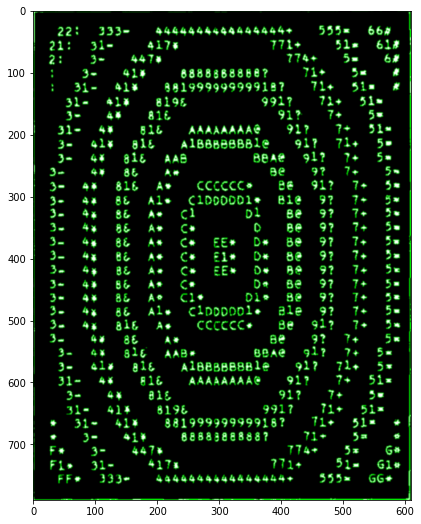

In [805]:
# mark ROI on an image
test_img = contour_img.copy()
roi = test_img[y:y+h,x:x+w]
# cv2.imwrite('contour91.jpg', roi)
plt.imshow(roi, cmap = 'gray', interpolation = 'bicubic')
# plt.rcParams["figure.figsize"] = [15, 9]
plt.show()

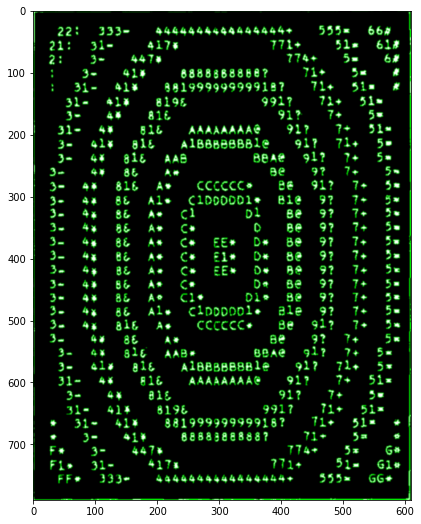

In [806]:
test_img = roi.copy()

plt.imshow(test_img, cmap = 'gray', interpolation = 'bicubic')
# plt.rcParams["figure.figsize"] = [15, 9]
plt.show()

In [807]:
# convert back to gray pic
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
# update contours
image_space, contours, hierarchy = cv2.findContours(test_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

309   384


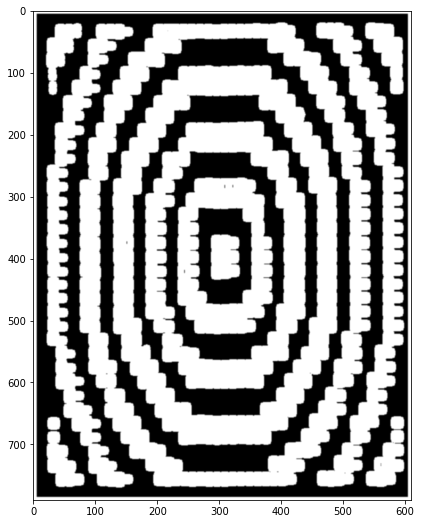

In [808]:
# produce moments of test_img
moments = cv2.moments(test_img)
# print(moments)

# calc x,y coords of center
Cx = int(moments['m10'] / moments['m00'])
Cy = int(moments['m01'] / moments['m00'])
print(Cx, ' ', Cy)

for c in contours:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(test_img, (x, y), (x + w, y + h), (255, 255, 255), 10)

plt.imshow(test_img, cmap = 'gray', interpolation = 'bicubic')
# plt.rcParams["figure.figsize"] = [15, 9]
plt.show()

In [809]:
# Pad an image with (255) for the use of contour detection on blank image
# border_thickness - a value of 1 indicates that the img_matrix will be surrounded by a border thickness 
# of size 1 (zeros are used for padding)
def padImage(img_matrix, border_thickness):
    padded_matrix = img_matrix.copy()
    # create top border
    vertical = np.zeros((border_thickness, padded_matrix.shape[1]), dtype=np.uint8)
#     vertical = vertical + 255
    padded_matrix = np.vstack((vertical, padded_matrix, vertical))

    horizontal = np.zeros((padded_matrix.shape[0], border_thickness), dtype=np.uint8)
#     horizontal = horizontal + 255
    padded_matrix = np.hstack((horizontal, padded_matrix, horizontal))
    return padded_matrix

In [810]:
# dimensions is a tuple of two ex: (x, y)
# x & y of dimensions must be greater than 0
def downScaleImage(image, dimensions):
    # make sure that shape of image is greater than input dimensions
    if image.shape[0] > dimensions[0] and image.shape[1] > dimensions[1]:
        # get scale factor
        row_scale_factor = image.shape[0] // dimensions[0]
        col_scale_factor = image.shape[1] // dimensions[1]
        scale_factor = (row_scale_factor, col_scale_factor)
        
        # create a new image
        resized_img = np.zeros((dimensions[0], dimensions[1]), dtype=np.uint8)
        
        # multiply indexes by scalefactor 
        for i in range(dimensions[0]):
            for j in range(dimensions[1]):
                resized_img[i][j] = image[i*scale_factor[0]][j*scale_factor[1]]
        return resized_img
    else:
        print('downScaleImage(..) requires dimensions to be smaller than original image')

### Resulting resized image of Task 1

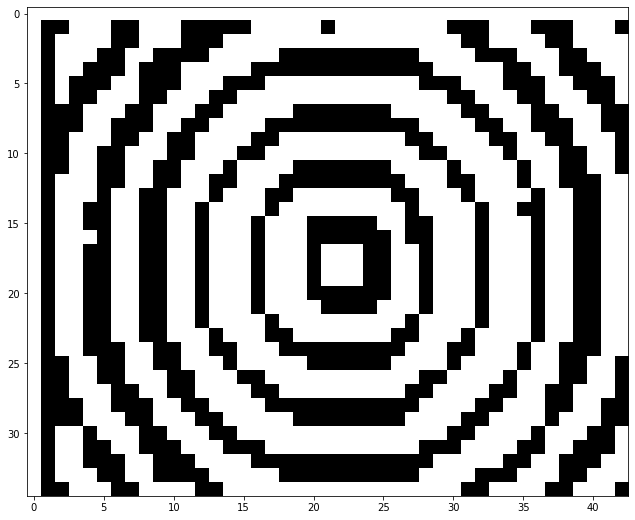

In [811]:
myImage = downScaleImage(test_img, (35,43))
plt.imshow(myImage, cmap='Greys_r')

### Task 2: Implementation of Contour Detection
Follows the algorithm 1 paper from Suzuki & Satoshi

In [812]:
# step 2: determine parent border of newly found border
# hier: a dict of hierarchy
# border_types: dict of border types
# nbd & lnbd are the respective border numbers
def addHierarchy(hier, border_types, nbd, lnbd):
    # each hierarchy is in the format:
    # index 0 = next contour, 1 = previous, 2 = first child (next level down), 3 = parent
    default_index = [-1,-1,-1,-1]

    # check if border exists
    if border_types.get(lnbd) == None:
        hier[lnbd] = default_index
    # add new hierarchy
    hier[nbd] = default_index
    # from fig. 1 of paper
    if border_types[lnbd] != border_types[nbd]:
        hier[nbd][-1] = lnbd
    else:# border_types[lnbd] == border_types[nbd]: 
        hier[nbd][-1] = hier[lnbd][-1]

In [813]:
# step 3.1: (clockwise)
# returns: end point or None
# img: image matrix
# origin: relative origin (i,j)
# start_coord: traverse in a clockwise direction starting at this coordinate
# border allows us to assign nbd to fij
def getClockwiseCoord(img, origin, start_coord, border):
    # pixel of interest (poi)
    poi = tuple(np.subtract(start_coord, origin))
    # create a list relative to the img neighborhood, we don't count the origin
    # translation format: NW, N, NE, E, SE, S, SW, W
    temp_list = [(-1,-1), (-1,0), (-1,1), (0,1), (1,1), (1,0), (1,-1), (0,-1)]
    # determine start index (direction)
    start_index = -1
    for i in range(len(temp_list)):
        if poi == temp_list[i]:
            start_index = i    
            break
    if start_index == -1:
        sys.exit('Within getClockwiseCoord(...) function: start_index never detected')

    for i in range(len(temp_list)):
        index = (start_index + i) % len(temp_list)
        row = origin[0] + temp_list[index][0]
        col = origin[1] + temp_list[index][1]
        if img[row][col] != 0:
            poi = tuple(np.add(origin, temp_list[index]))
            # returning the first nonzero pixel coordinate
            return poi
    # If no nonzero pixel is found go to step #4
    img[origin[0]][origin[1]] = -border['nbd']
    return None 

In [814]:
# step 3.3 (counterclockwise)
# returns: next point or None
# img: image matrix
# origin: relative origin (i3,j3)
# previous_coord: traverse in a counterclockwise direction starting at this coordinate
def getCounterClockwiseCoord(img, origin, previous_coord):
    poi = tuple(np.subtract(previous_coord, origin))

    # create a list relative to the img neighborhood, we don't count the origin
    # translation format: NW, W, SW, S, SE, E, NE, N
    temp_list = [(-1,-1), (0,-1), (1,-1), (1,0), (1,1), (0,1), (-1,1), (-1,0)]
    # determine start index (direction)
    start_index = -1
    for i in range(len(temp_list)):
        if poi == temp_list[i]:
            start_index = i + 1 # start from the next element of (i2,j2)
            break
    if start_index == -1:
        sys.exit('Within getCounterClockwiseCoord(...) function: start_index never detected')
  
    for i in range(len(temp_list)):
        index = (start_index + i) % len(temp_list)
        row = origin[0] + temp_list[index][0]
        col = origin[1] + temp_list[index][1]
        if img[row][col] != 0:
            poi = tuple(np.add(origin, temp_list[index]))
            # returning the first nonzero pixel coordinate
            return poi
    sys.exit('Within getCounterClockwiseCoord(...) function: next point never found')

In [815]:
# step 3
def traceContour(img, row, col, previous_coord, border):
    coordinates = {'starting_point':None, 'end_point':None, 'previous_point':None,
                   'current_point':None, 'next_point':None} 
    # step 3.1 clockwise
    origin = (row, col)
    coordinates['end_point'] = getClockwiseCoord(img, origin, previous_coord, border)
    # if nonzero pixel not found, will go to step #4
    if coordinates['end_point'] == None:
        if scanner != 1:
            border['lnbd'] = abs(scanner)
    else:
        # step 3.2
        coordinates['starting_point'] = (row, col)
        coordinates['previous_point'] = coordinates['end_point']
        coordinates['current_point'] = coordinates['starting_point']
        # start tracing via counter clockwise starting with previous_point
        while True:
            # (step 3.3)
            coordinates['next_point'] = getCounterClockwiseCoord(img, coordinates['current_point'], coordinates['previous_point'])
            if coordinates['next_point'] == None:
                sys.exit('traceContour function: did NOT detect next_point')
            # step 3.4
            temp_row = coordinates['current_point'][0]
            temp_col = coordinates['current_point'][1]
            # step 3.4 a)
            if img[temp_row][temp_col+1] == 0: 
                img[temp_row][temp_col] = -border['nbd']
            # step 3.4 b)
            elif img[temp_row][temp_col+1] != 0 and img[temp_row][temp_col] == 1: 
                img[temp_row][temp_col] = border['nbd']
            # step 3.4 c)
            # otherwise do not change f(i3, j3)
        
            # step 3.5
            if (coordinates['next_point'] == coordinates['starting_point'] and 
            coordinates['current_point'] == coordinates['end_point']):
            # go to step 4
                break
            else:
                coordinates['previous_point'] = coordinates['current_point']
                coordinates['current_point'] = coordinates['next_point']
                # update row and col values
                row, col = coordinates['next_point']
                # go back to step 3.3

### This represents my find Contour function

In [818]:
# create a toy example of an image (4x9) pad image to become: (6x11)
toy_img = np.array([[1, 1, 1, 1, 1, 1, 1, 0, 0], [1, 0, 0, 1, 0, 0, 1, 0, 1], [1, 0, 0, 1, 0, 0, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 0, 0]], np.int8)

# Must pad image first with one layer, then process pixels within the padding
toy_img = padImage(toy_img, 1)
print('Before:')
print(toy_img)

# Declare variables to be used in loop:
# starting_point (i,j)
# end_point      (i1,j1)
# previous_point (i2,j2) 
# current_point  (i3,j3)   
# next_point     (i4,j4) 
coord = {'starting_point':None, 'end_point':None, 'previous_point':None,
         'current_point':None, 'next_point':None} 
border = {'nbd':1, 'lnbd':1} # representing the sequential borders

# keep track of the hierarchy of contours:
hierarchy = {}
hierarchy[border['lnbd']] = [-1,-1,-1,-1]
# keep track of the type of borders key=(number), value=OUTER or HOLE
OUTER = 1
HOLE = 0
border_types = {}
# initial frame considered as hole border
border_types[border['lnbd']] = HOLE

# make a copy of the original image and convert non zero values to 1
# ...(do this when moving on to actual image)

# scanning raster
for row in range(1,toy_img.shape[0]-1):
    # reset lnbd to 1 at the beginning of each row visit
    border['lnbd'] = 1
    # reset bool values for next step
    outer_border = False  # outer border type
    hole_border = False   # hole border type

    for col in range(1,toy_img.shape[1]-1):
        scanner = toy_img[row][col]
        left_pixel = toy_img[row][col-1]
        right_pixel = toy_img[row][col+1]
        # 1a) case: starting point of outer border found
        if scanner == 1 and left_pixel == 0:
            coord['previous_point'] = (row, col-1)
            outer_border = True
            coord['starting_point'] = (row, col)
            border['nbd'] += 1

            # assign nbd its border type
            border_types[border['nbd']] = OUTER
            # 2) determine parent border of newly found border
            addHierarchy(hierarchy, border_types, border['nbd'], border['lnbd'])

            # 3) trace detected border
            traceContour(toy_img, row, col, coord['previous_point'], border)

        # 1b) case: starting point of hole border found
        elif scanner >= 1 and right_pixel == 0:
            coord['previous_point'] = (row, col+1)
            if scanner > 1:
                border['lnbd'] = scanner
            hole_border = True
            coord['starting_point'] = (row, col)
            border['nbd'] += 1

            # assign nbd its border type
            border_types[border['nbd']] = HOLE
            # 2) determine parent border of newly found border
            addHierarchy(hierarchy, border_types, border['nbd'], border['lnbd'])

            # 3) trace detected border
            traceContour(toy_img, row, col, coord['previous_point'], border)

        # 1c) step 4 of Algorithm 1 paper
        elif scanner != 1 and scanner != 0:
            border['lnbd'] = abs(scanner)
            continue

# check: same parents indicate that borders are on same level
# not enough time to implement

print('After')
print(toy_img)

Before:
[[0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 0 0 0]
 [0 1 0 0 1 0 0 1 0 1 0]
 [0 1 0 0 1 0 0 1 0 0 0]
 [0 1 1 1 1 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]
After
[[ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  2  2  2  2  2 -2  0  0  0]
 [ 0 -3  0  0 -3  0  0 -2  0 -4  0]
 [ 0 -3  0  0 -3  0  0 -2  0  0  0]
 [ 0  2  2  2  2  2  2 -2  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]]


### Notice from 'Before' and 'After' output we get something closely similar to the resulting algorithm 1 paper.

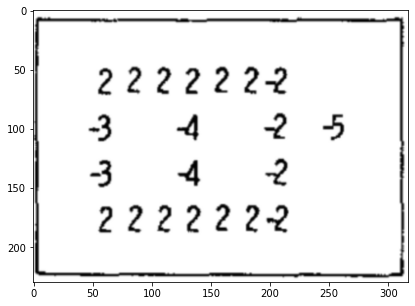

In [821]:
img = cv2.imread('/Users/johnsonFreemanClarke/Desktop/5190/images/toy_img_result.png')
 
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.rcParams["figure.figsize"] = [7, 5]
plt.show()